# Introduction

We are going to attempt to statiscally analyze the effectiveness of the Broken Windows implementation in the city of New York. The data comes from the us census bureau. By way of bayesian inferecen and a Monty Carlo Makov Chain simulation we will recreate the dictibutions that these crime numbers derive and compare the two populations.

If the two populations are zero or close to it, that will tell us that they are similar showing that the policy change didn have much of and effect. If they are drastically dirfferent then the policy had a major effect on crime.

In [1]:
#Import Libraries to be used later
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')
import numpy as np

In [2]:
'''
#Reading in the data
cr = pd.read_csv('crime.csv')
'''

"\n#Reading in the data\ncr = pd.read_csv('crime.csv')\n"

In [3]:
'''
#Sorting for only nyc information
df = cr[cr.Region == 'New York City']
nyc_tot = df[df.County == 'Region Total']
#Dropping unwanted columns
nyc_tot = nyc_tot.drop(nyc_tot[['Agency', 'Months Reported', 'County']], axis=1)
# Renaming columns
nyc_tot=nyc_tot.rename(columns={'Violent Total': 'Violent_Total',
                       'Index Total':'Total',
                               'Property Total':'Property_Total',
                               'Aggravated Assault':'Aggravated_Assault'})
# Changingthe inddex to year
nyc_tot.set_index('Year', inplace=True)
'''

"\n#Sorting for only nyc information\ndf = cr[cr.Region == 'New York City']\nnyc_tot = df[df.County == 'Region Total']\n#Dropping unwanted columns\nnyc_tot = nyc_tot.drop(nyc_tot[['Agency', 'Months Reported', 'County']], axis=1)\n# Renaming columns\nnyc_tot=nyc_tot.rename(columns={'Violent Total': 'Violent_Total',\n                       'Index Total':'Total',\n                               'Property Total':'Property_Total',\n                               'Aggravated Assault':'Aggravated_Assault'})\n# Changingthe inddex to year\nnyc_tot.set_index('Year', inplace=True)\n"

In [4]:
#Saving split data to csv for easy access later.
'''
nyc_tot.to_csv('crime02.csv')
'''

"\nnyc_tot.to_csv('crime02.csv')\n"

# EDA
Lets look at the columns in question regarding broken glass.
On the surface level we'll see if the trends in crime did decrease

In [5]:
nyc_tot = pd.read_csv('crime02.csv')

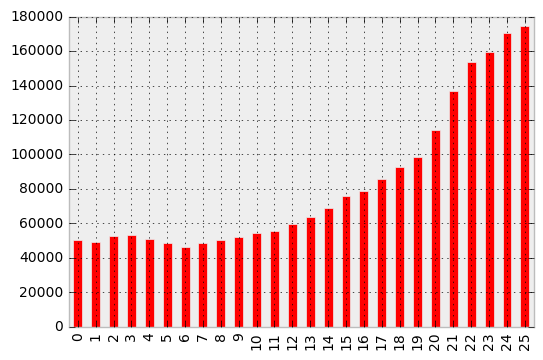

In [6]:
#The number of violient crime potted
nyc_tot.Violent_Total.plot(kind='bar', color= 'red')

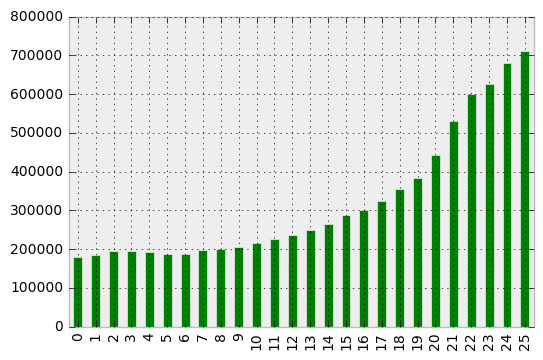

In [7]:
# Total number of crimes plotted
nyc_tot.Total.plot(kind='bar', color= 'green')

So it looks like crime has fallen in categories every year. With '25' representing the year 1990 and '0' represeting the year 2015
Lets see the relations together

Lets see how well minor  crimes can predict the number of crimes


# Baysian Inference

In [8]:
# Reading in Data
nys = pd.read_csv('ny_crime_hist2.csv')
nyc = pd.read_csv('nyc_crime_hist2')

In [9]:
# Sectioning data for target populations
nyc_81 = nyc[nyc.Year < 1990].city_crime_total.values
nyc_10 = nyc[(nyc.Year >= 1990)].city_crime_total.values

In [10]:
#Setting up priors for Bayesian Inference
#The priors we will use are for the two populations are the means and standard deviations
#For those time frames


#Priors for population before 1990
mean_prior_mean_before90 = nyc_81.mean()
mean_prior_std_before90 = nyc_81.std()

#Priors for population after 1990
mean_prior_mean_after90 = nyc_10.mean()
mean_prior_std_after90 = nyc_10.std()

In [11]:
# fitting prior means
with pm.Model() as model:
    before90_mean = pm.Normal('before90_mean', mean_prior_mean_before90, sd=mean_prior_std_before90)
    after90_mean = pm.Normal('after90_mean', mean_prior_mean_after90, sd=mean_prior_std_after90)

# fitting prior standard deviations
#setting lower and upper bounds
#the upper bounds are 2 * the std for each population. This will give us a good range.
std_prior_lower = 0.01
std_prior_upper_before90 = (np.std(nyc_81)) * 2
std_prior_upper_after90 = (np.std(nyc_10)) * 2

# fitting model with prior std
with model:
    before90_std = pm.Uniform('before90_std', lower=std_prior_lower, upper=std_prior_upper_before90)
    after90_std = pm.Uniform('after90_std', lower=std_prior_lower, upper=std_prior_upper_after90)

In [12]:
# Fitting model
with model:
    before90 = pm.Normal('Before90', mu=before90_mean, sd=before90_std, observed=nyc_81)
    after90 = pm.Normal('After90', mu=after90_mean, sd=after90_std, observed=nyc_10)
# Creating addtional metrics for comparison of populations
with model:

    diff_of_means = pm.Deterministic('difference of means', before90_mean - after90_mean)
    diff_of_stds = pm.Deterministic('difference of stds', before90_std - after90_std)
    effect_size = pm.Deterministic('effect size',
                                   diff_of_means / np.sqrt((before90_std**2 + after90_std**2) / 2))

In [13]:
# Running simulations of new populations ditributions
with model:
    trace = pm.sample(25000, njobs=-1)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -381.23: 100%|██████████| 200000/200000 [00:36<00:00, 5545.46it/s]
Finished [100%]: Average ELBO = -381.2
100%|██████████| 25000/25000 [00:48<00:00, 520.23it/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1172d1c90>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1177e1050>], dtype=object)

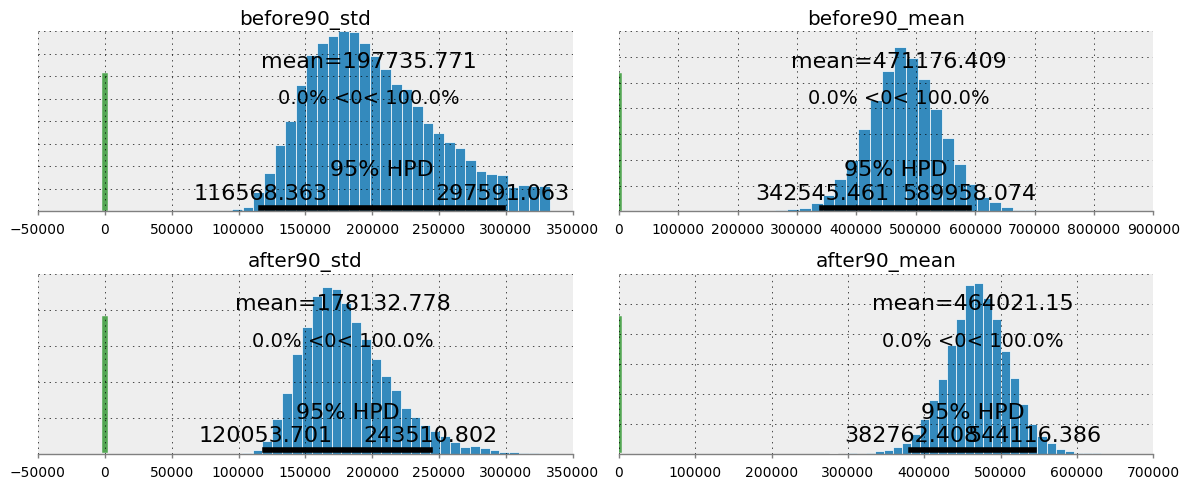

In [14]:
#Plotting new distrubutions
plt.rcParams['figure.figsize'] = (24, 18)
pm.plot_posterior(trace[2000:],
                 varnames=['before90_mean', 'after90_mean', 'before90_std', 'after90_std'],
                  ref_val=0)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x117f520d0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x118761890>], dtype=object)

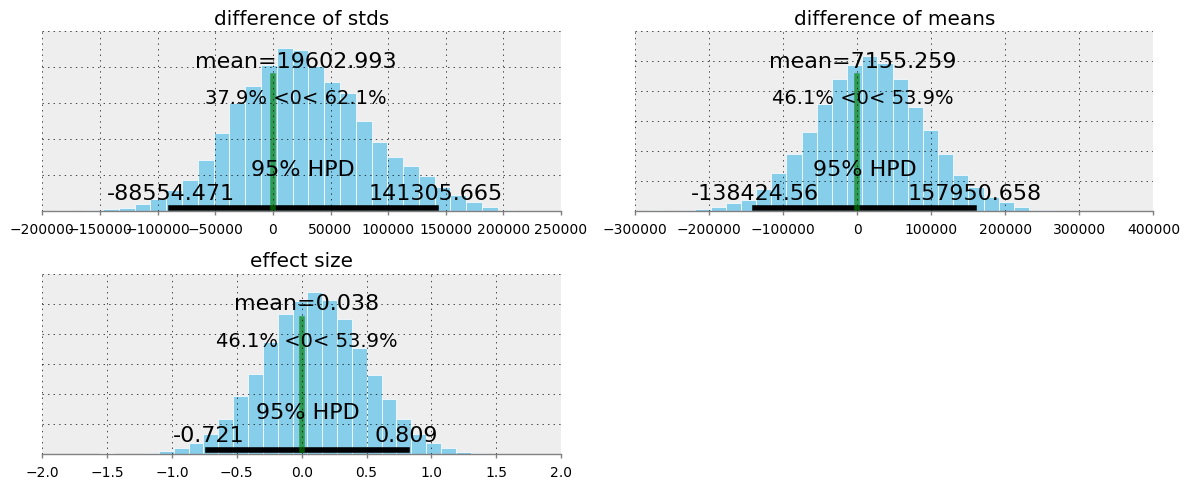

In [15]:
#Plotting comparison Metrics
pm.plot_posterior(trace[2000:],
                  varnames=['difference of means', 'difference of stds', 'effect size'],
                  ref_val=0,
                  color='#87ceeb')

# Conclusion


So looking at our difference of means metric (One population subtracted the other) we can see there isnt much difference between the two populations. Because our population time frames are spilt by the enforecement of broken windows we can see that there wasnt are large diffecent in crime after. So we can loosely conclude that the effect of broken windows was not a drastic one and other factors should be explored in realtion to lower crime rates in NY.